In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

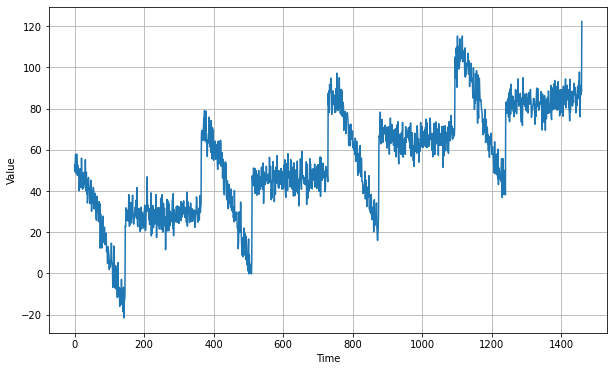

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
# Preprocessing With 1D-Convolutional Layers

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 7s 905ms/step - loss: 87.4947 - mae: 88.3356
Epoch 2/100
8/8 [==============================] - 2s 212ms/step - loss: 86.8595 - mae: 87.6112
Epoch 3/100
8/8 [==============================] - 2s 230ms/step - loss: 86.0590 - mae: 86.4322
Epoch 4/100
8/8 [==============================] - 2s 208ms/step - loss: 84.4441 - mae: 84.8714
Epoch 5/100
8/8 [==============================] - 2s 200ms/step - loss: 82.4501 - mae: 82.9793
Epoch 6/100
8/8 [==============================] - 2s 205ms/step - loss: 80.5388 - mae: 80.7489
Epoch 7/100
8/8 [==============================] - 2s 198ms/step - loss: 77.8250 - mae: 78.2492
Epoch 8/100
8/8 [==============================] - 2s 212ms/step - loss: 75.2095 - mae: 75.6000
Epoch 9/100
8/8 [==============================] - 2s 224ms/step - loss: 72.3287 - mae: 72.9481
Epoch 10/100
8/8 [==============================] - 2s 216ms/step - loss: 69.9495 - mae: 70.4036
Epoch 11/100
8/8 [=====================

8/8 [==============================] - 2s 296ms/step - loss: 18.6806 - mae: 19.4651
Epoch 87/100
8/8 [==============================] - 2s 245ms/step - loss: 14.2100 - mae: 14.6124
Epoch 88/100
8/8 [==============================] - 2s 264ms/step - loss: 13.1688 - mae: 13.4579
Epoch 89/100
8/8 [==============================] - 2s 221ms/step - loss: 23.5675 - mae: 23.6169
Epoch 90/100
8/8 [==============================] - 2s 255ms/step - loss: 21.9132 - mae: 21.8547
Epoch 91/100
8/8 [==============================] - 2s 248ms/step - loss: 14.9897 - mae: 16.4415
Epoch 92/100
8/8 [==============================] - 2s 222ms/step - loss: 15.1212 - mae: 15.7686
Epoch 93/100
8/8 [==============================] - 2s 222ms/step - loss: 17.0247 - mae: 17.3067
Epoch 94/100
8/8 [==============================] - 2s 223ms/step - loss: 15.6509 - mae: 16.3976
Epoch 95/100
8/8 [==============================] - 2s 240ms/step - loss: 15.6255 - mae: 16.0402
Epoch 96/100
8/8 [=========================

(1e-08, 0.0001, 0.0, 30.0)

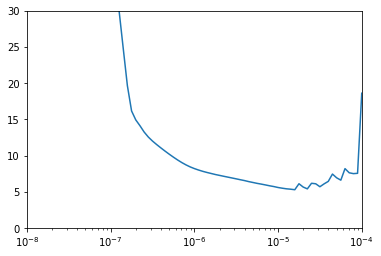

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=150,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/150
8/8 [==============================] - 9s 1s/step - loss: 57.1561 - mae: 58.2706 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/150
8/8 [==============================] - 2s 236ms/step - loss: 24.1624 - mae: 24.3364 - val_loss: 35.8343 - val_mae: 36.9375
Epoch 3/150
8/8 [==============================] - 2s 235ms/step - loss: 16.7320 - mae: 17.2362 - val_loss: 37.3009 - val_mae: 37.5001
Epoch 4/150
8/8 [==============================] - 2s 241ms/step - loss: 14.4453 - mae: 14.3808 - val_loss: 22.6559 - val_mae: 23.4096
Epoch 5/150
8/8 [==============================] - 2s 242ms/step - loss: 11.1129 - mae: 11.3806 - val_loss: 19.1821 - val_mae: 19.7705
Epoch 6/150
8/8 [==============================] - 2s 242ms/step - loss: 9.3560 - mae: 9.5911 - val_loss: 16.4036 - val_mae: 16.9639
Epoch 7/150
8/8 [==============================] - 2s 240ms/step - loss: 7.9507 - mae: 8.4399 - val_loss: 16.3301 - val_mae: 16.9760
Epoch 8/150
8/8 [==============================] - 2s 24

Epoch 63/150
8/8 [==============================] - 2s 289ms/step - loss: 4.5503 - mae: 5.0345 - val_loss: 6.3726 - val_mae: 6.8072
Epoch 64/150
8/8 [==============================] - 2s 293ms/step - loss: 4.5789 - mae: 5.0453 - val_loss: 5.8951 - val_mae: 6.3878
Epoch 65/150
8/8 [==============================] - 3s 319ms/step - loss: 4.5456 - mae: 5.0480 - val_loss: 6.5525 - val_mae: 7.0602
Epoch 66/150
8/8 [==============================] - 2s 292ms/step - loss: 4.5950 - mae: 5.0904 - val_loss: 7.5471 - val_mae: 8.1662
Epoch 67/150
8/8 [==============================] - 2s 288ms/step - loss: 4.6112 - mae: 5.0704 - val_loss: 7.1930 - val_mae: 7.7086
Epoch 68/150
8/8 [==============================] - 2s 285ms/step - loss: 4.6212 - mae: 5.0938 - val_loss: 7.0025 - val_mae: 7.5145
Epoch 69/150
8/8 [==============================] - 3s 319ms/step - loss: 4.7074 - mae: 5.1421 - val_loss: 5.8158 - val_mae: 6.2994
Epoch 70/150
8/8 [==============================] - 3s 355ms/step - loss: 4.

Epoch 125/150
8/8 [==============================] - 3s 336ms/step - loss: 4.3627 - mae: 4.8734 - val_loss: 6.9810 - val_mae: 7.4234
Epoch 126/150
8/8 [==============================] - 3s 359ms/step - loss: 4.4495 - mae: 4.9004 - val_loss: 5.3304 - val_mae: 5.8692
Epoch 127/150
8/8 [==============================] - 2s 292ms/step - loss: 4.4804 - mae: 4.9366 - val_loss: 6.7360 - val_mae: 7.2161
Epoch 128/150
8/8 [==============================] - 2s 281ms/step - loss: 4.5310 - mae: 4.9810 - val_loss: 5.8902 - val_mae: 6.4356
Epoch 129/150
8/8 [==============================] - 2s 307ms/step - loss: 4.3517 - mae: 4.8335 - val_loss: 5.4412 - val_mae: 5.9458
Epoch 130/150
8/8 [==============================] - 2s 278ms/step - loss: 4.4014 - mae: 4.8593 - val_loss: 6.2205 - val_mae: 6.6829
Epoch 131/150
8/8 [==============================] - 2s 276ms/step - loss: 4.3698 - mae: 4.8241 - val_loss: 5.6325 - val_mae: 6.1408
Epoch 132/150
8/8 [==============================] - 2s 278ms/step - 

In [10]:
# Fully Convolutional Forecasting

In [11]:
model = tf.keras.models.load_model("my_checkpoint.h5")

In [12]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

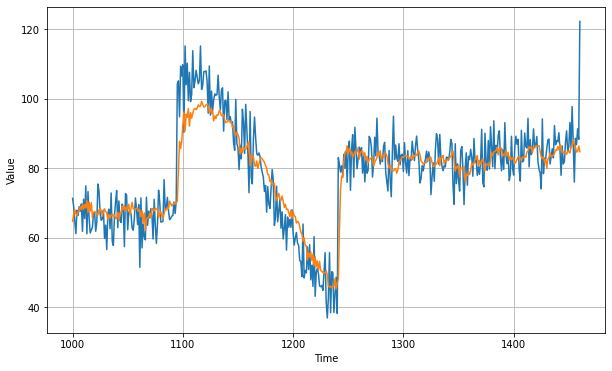

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.1828675

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      tf.keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 465ms/step - loss: 42.1616 - mae: 42.7348
Epoch 2/100
8/8 [==============================] - 1s 153ms/step - loss: 41.8518 - mae: 42.3290
Epoch 3/100
8/8 [==============================] - 1s 173ms/step - loss: 41.5584 - mae: 41.9345
Epoch 4/100
8/8 [==============================] - 2s 196ms/step - loss: 41.1315 - mae: 41.5100
Epoch 5/100
8/8 [==============================] - 1s 157ms/step - loss: 40.6201 - mae: 40.9796
Epoch 6/100
8/8 [==============================] - 1s 155ms/step - loss: 39.4540 - mae: 40.2333
Epoch 7/100
8/8 [==============================] - 1s 154ms/step - loss: 38.7233 - mae: 39.1041
Epoch 8/100
8/8 [==============================] - 1s 154ms/step - loss: 36.6903 - mae: 37.1633
Epoch 9/100
8/8 [==============================] - 1s 168ms/step - loss: 33.4870 - mae: 33.8624
Epoch 10/100
8/8 [==============================] - 1s 157ms/step - loss: 28.0736 - mae: 28.4693
Epoch 11/100
8/8 [=====================

8/8 [==============================] - 1s 182ms/step - loss: 15.5262 - mae: 15.7228
Epoch 87/100
8/8 [==============================] - 1s 177ms/step - loss: 17.0975 - mae: 17.6768
Epoch 88/100
8/8 [==============================] - 1s 179ms/step - loss: 13.4906 - mae: 13.7827
Epoch 89/100
8/8 [==============================] - 2s 196ms/step - loss: 8.6924 - mae: 9.1921
Epoch 90/100
8/8 [==============================] - 2s 237ms/step - loss: 11.1333 - mae: 11.4551
Epoch 91/100
8/8 [==============================] - 2s 245ms/step - loss: 7.7719 - mae: 8.2002
Epoch 92/100
8/8 [==============================] - 2s 232ms/step - loss: 8.6864 - mae: 9.0706
Epoch 93/100
8/8 [==============================] - 2s 207ms/step - loss: 7.3946 - mae: 7.9837
Epoch 94/100
8/8 [==============================] - 2s 190ms/step - loss: 9.1222 - mae: 9.7119
Epoch 95/100
8/8 [==============================] - 2s 189ms/step - loss: 14.3057 - mae: 14.4591
Epoch 96/100
8/8 [==============================] - 2

(0.0001, 0.1, 0.0, 30.0)

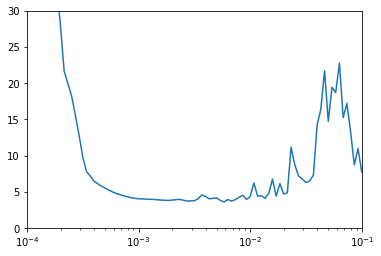

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      tf.keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = tf.keras.optimizers.Adam(lr=3e-4)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=150,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/150
8/8 [==============================] - 4s 514ms/step - loss: 40.0589 - mae: 40.6938 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/150
8/8 [==============================] - 2s 204ms/step - loss: 38.2967 - mae: 38.6062 - val_loss: 68.0121 - val_mae: 68.4613
Epoch 3/150
8/8 [==============================] - 2s 203ms/step - loss: 35.0624 - mae: 35.5927 - val_loss: 60.6271 - val_mae: 61.3196
Epoch 4/150
8/8 [==============================] - 2s 206ms/step - loss: 31.5355 - mae: 31.3079 - val_loss: 50.3134 - val_mae: 50.6322
Epoch 5/150
8/8 [==============================] - 2s 238ms/step - loss: 25.5509 - mae: 25.4281 - val_loss: 36.3013 - val_mae: 37.1148
Epoch 6/150
8/8 [==============================] - 2s 307ms/step - loss: 20.4346 - mae: 20.6456 - val_loss: 31.7196 - val_mae: 32.5077
Epoch 7/150
8/8 [==============================] - 2s 281ms/step - loss: 18.9350 - mae: 19.3888 - val_loss: 29.5587 - val_mae: 30.5285
Epoch 8/150
8/8 [==============================] 

Epoch 63/150
8/8 [==============================] - 2s 305ms/step - loss: 3.7792 - mae: 4.2577 - val_loss: 4.2716 - val_mae: 4.7480
Epoch 64/150
8/8 [==============================] - 3s 425ms/step - loss: 3.7837 - mae: 4.2500 - val_loss: 4.2259 - val_mae: 4.7254
Epoch 65/150
8/8 [==============================] - 3s 381ms/step - loss: 3.7672 - mae: 4.2439 - val_loss: 4.2545 - val_mae: 4.7256
Epoch 66/150
8/8 [==============================] - 3s 365ms/step - loss: 3.7710 - mae: 4.2390 - val_loss: 4.1974 - val_mae: 4.7239
Epoch 67/150
8/8 [==============================] - 3s 398ms/step - loss: 3.7660 - mae: 4.2337 - val_loss: 4.3521 - val_mae: 4.8077
Epoch 68/150
8/8 [==============================] - 3s 329ms/step - loss: 3.7582 - mae: 4.2341 - val_loss: 4.2474 - val_mae: 4.7118
Epoch 69/150
8/8 [==============================] - 2s 288ms/step - loss: 3.7549 - mae: 4.2229 - val_loss: 4.2881 - val_mae: 4.7285
Epoch 70/150
8/8 [==============================] - 2s 312ms/step - loss: 3.

Epoch 125/150
8/8 [==============================] - 3s 367ms/step - loss: 3.4760 - mae: 3.9260 - val_loss: 4.2472 - val_mae: 4.7387
Epoch 126/150
8/8 [==============================] - 2s 301ms/step - loss: 3.4532 - mae: 3.9222 - val_loss: 4.1969 - val_mae: 4.7205
Epoch 127/150
8/8 [==============================] - 3s 325ms/step - loss: 3.4460 - mae: 3.9200 - val_loss: 4.2164 - val_mae: 4.7114
Epoch 128/150
8/8 [==============================] - 3s 333ms/step - loss: 3.4738 - mae: 3.9155 - val_loss: 4.4008 - val_mae: 4.8605
Epoch 129/150
8/8 [==============================] - 3s 315ms/step - loss: 3.4440 - mae: 3.9135 - val_loss: 4.2715 - val_mae: 4.7817
Epoch 130/150
8/8 [==============================] - 3s 320ms/step - loss: 3.4492 - mae: 3.9069 - val_loss: 4.1892 - val_mae: 4.7150
Epoch 131/150
8/8 [==============================] - 3s 332ms/step - loss: 3.4555 - mae: 3.9033 - val_loss: 4.2467 - val_mae: 4.7258
Epoch 132/150
8/8 [==============================] - 2s 307ms/step - 

In [18]:
model = tf.keras.models.load_model("my_checkpoint.h5")

In [19]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

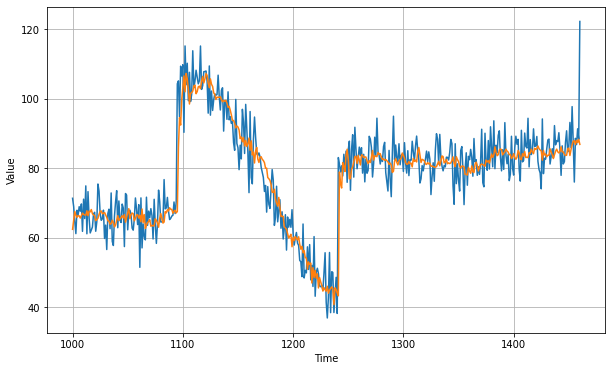

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.5677795